<hr style="height:2px;border-width:0;color:gray;background-color:black">

$\large \mathbf{1}$

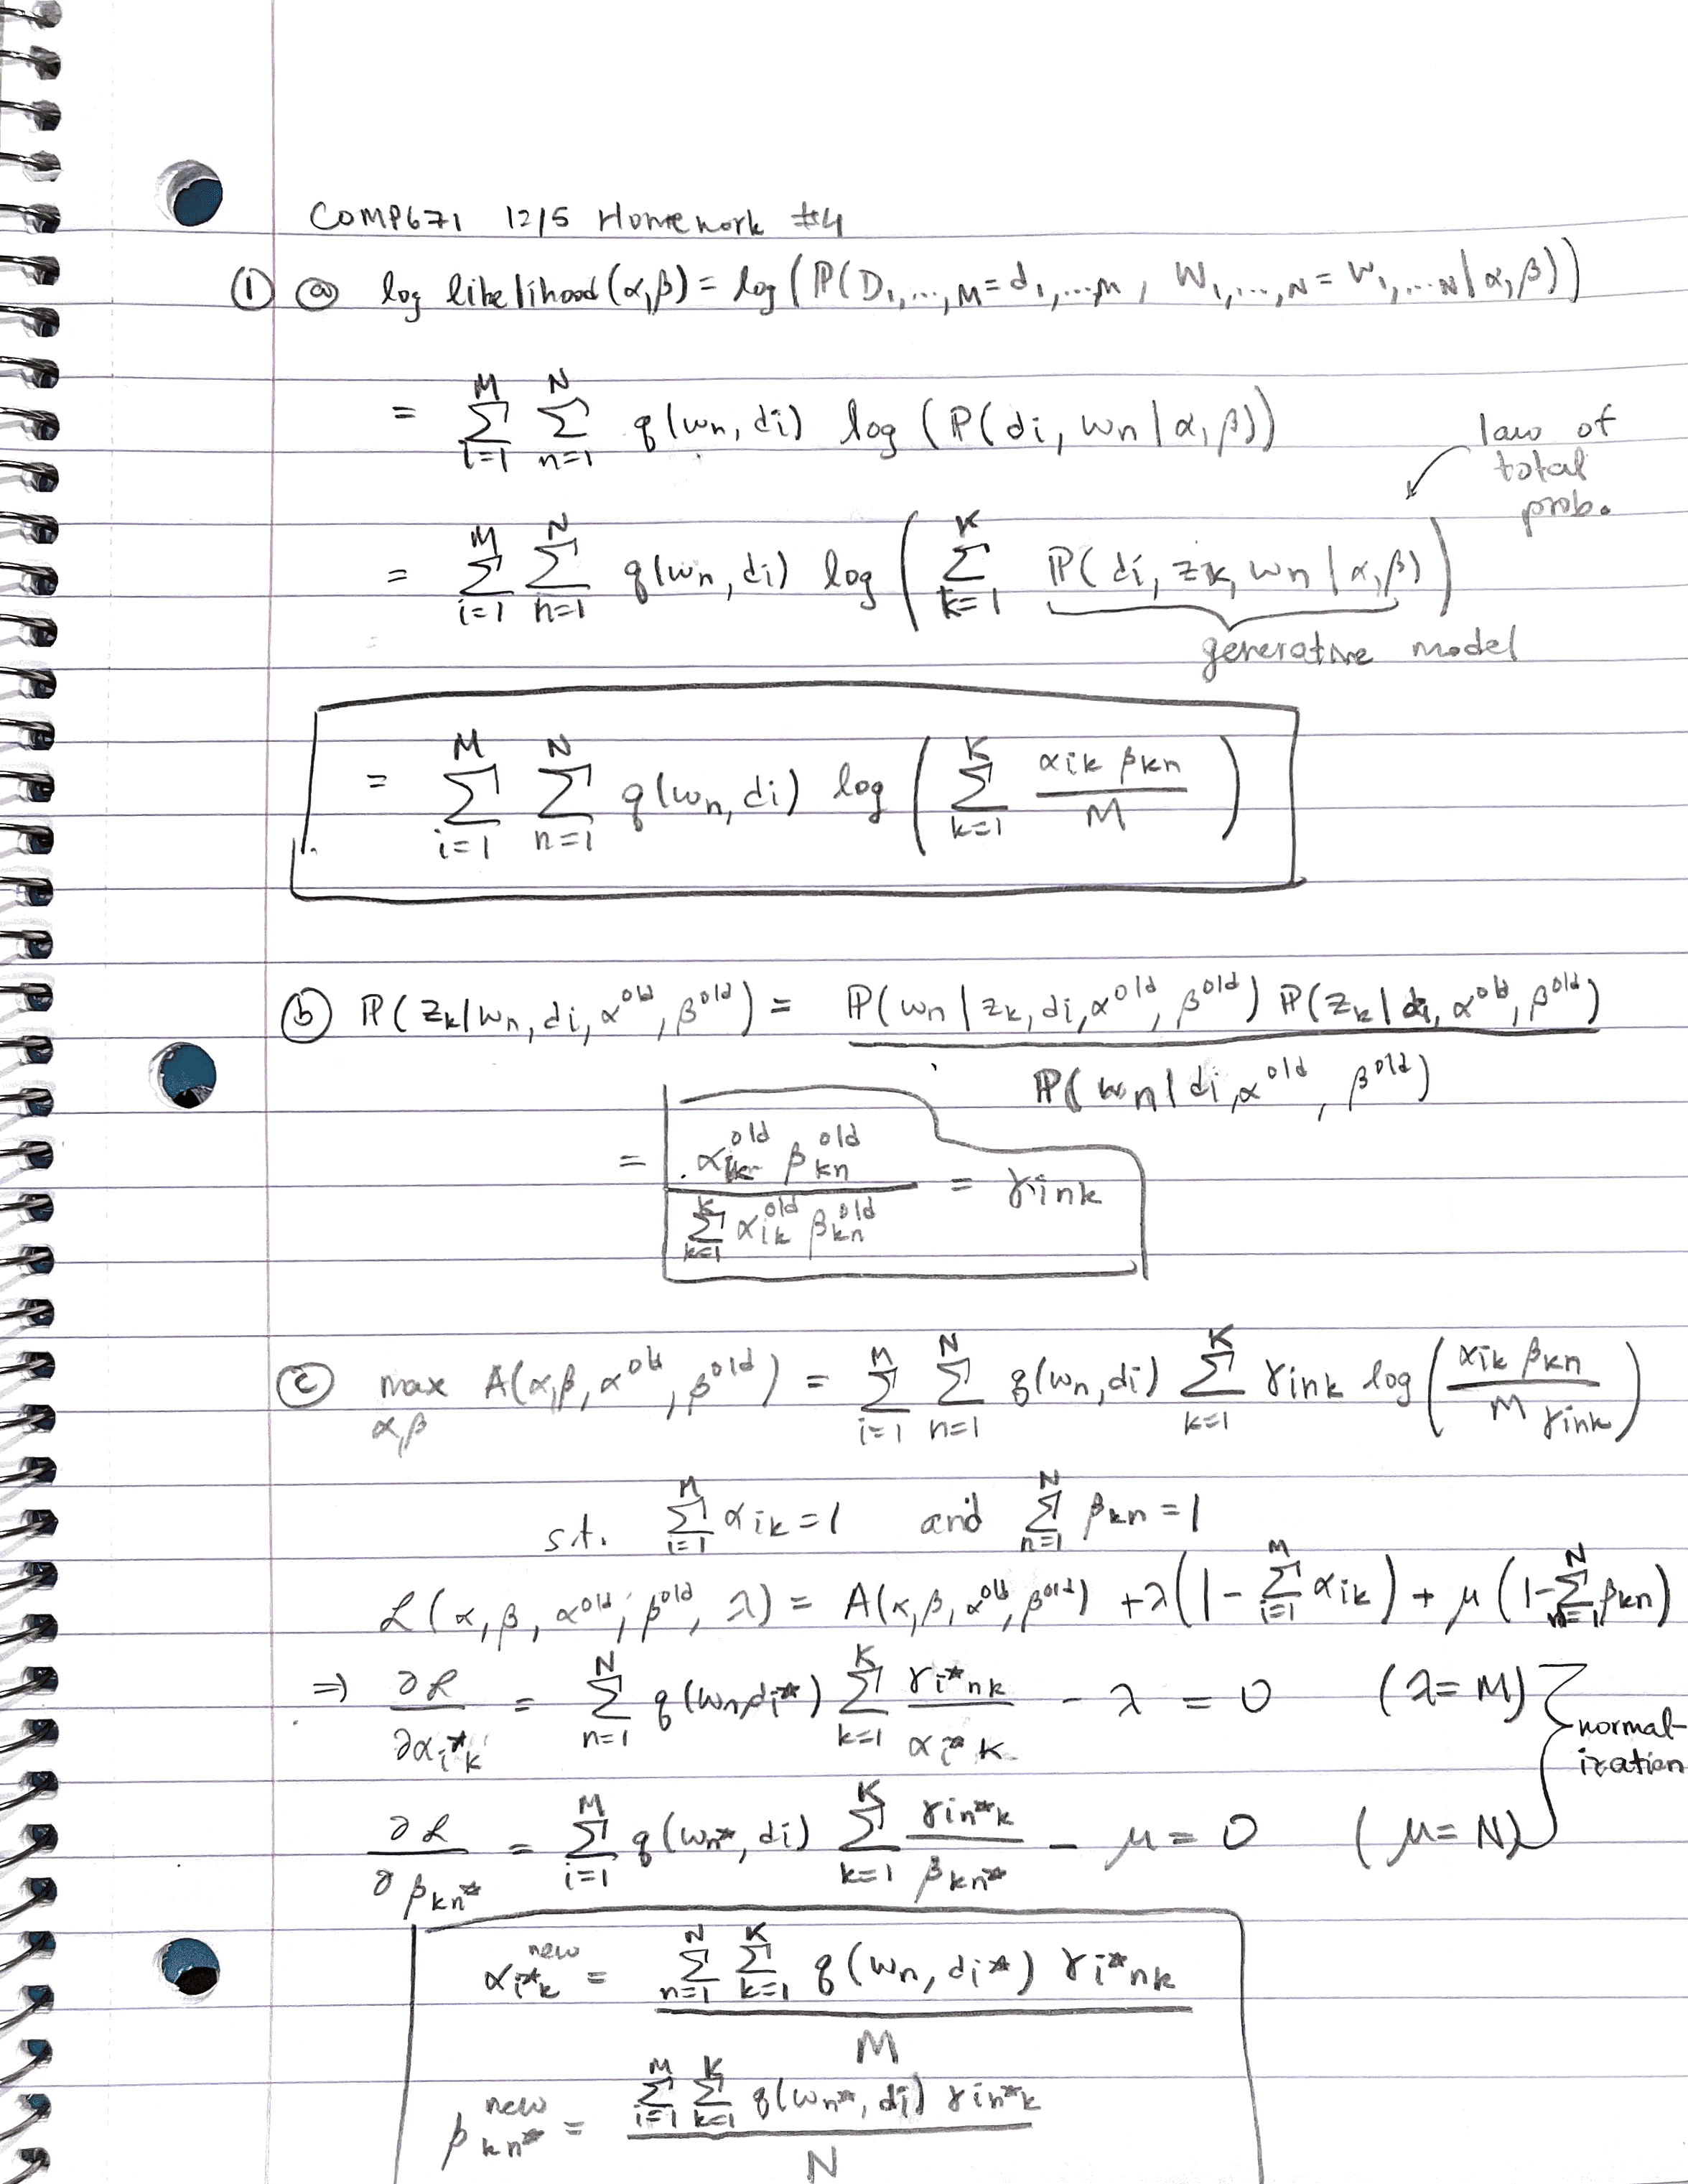

<hr style="height:2px;border-width:0;color:gray;background-color:black">

$\large \mathbf{2}$

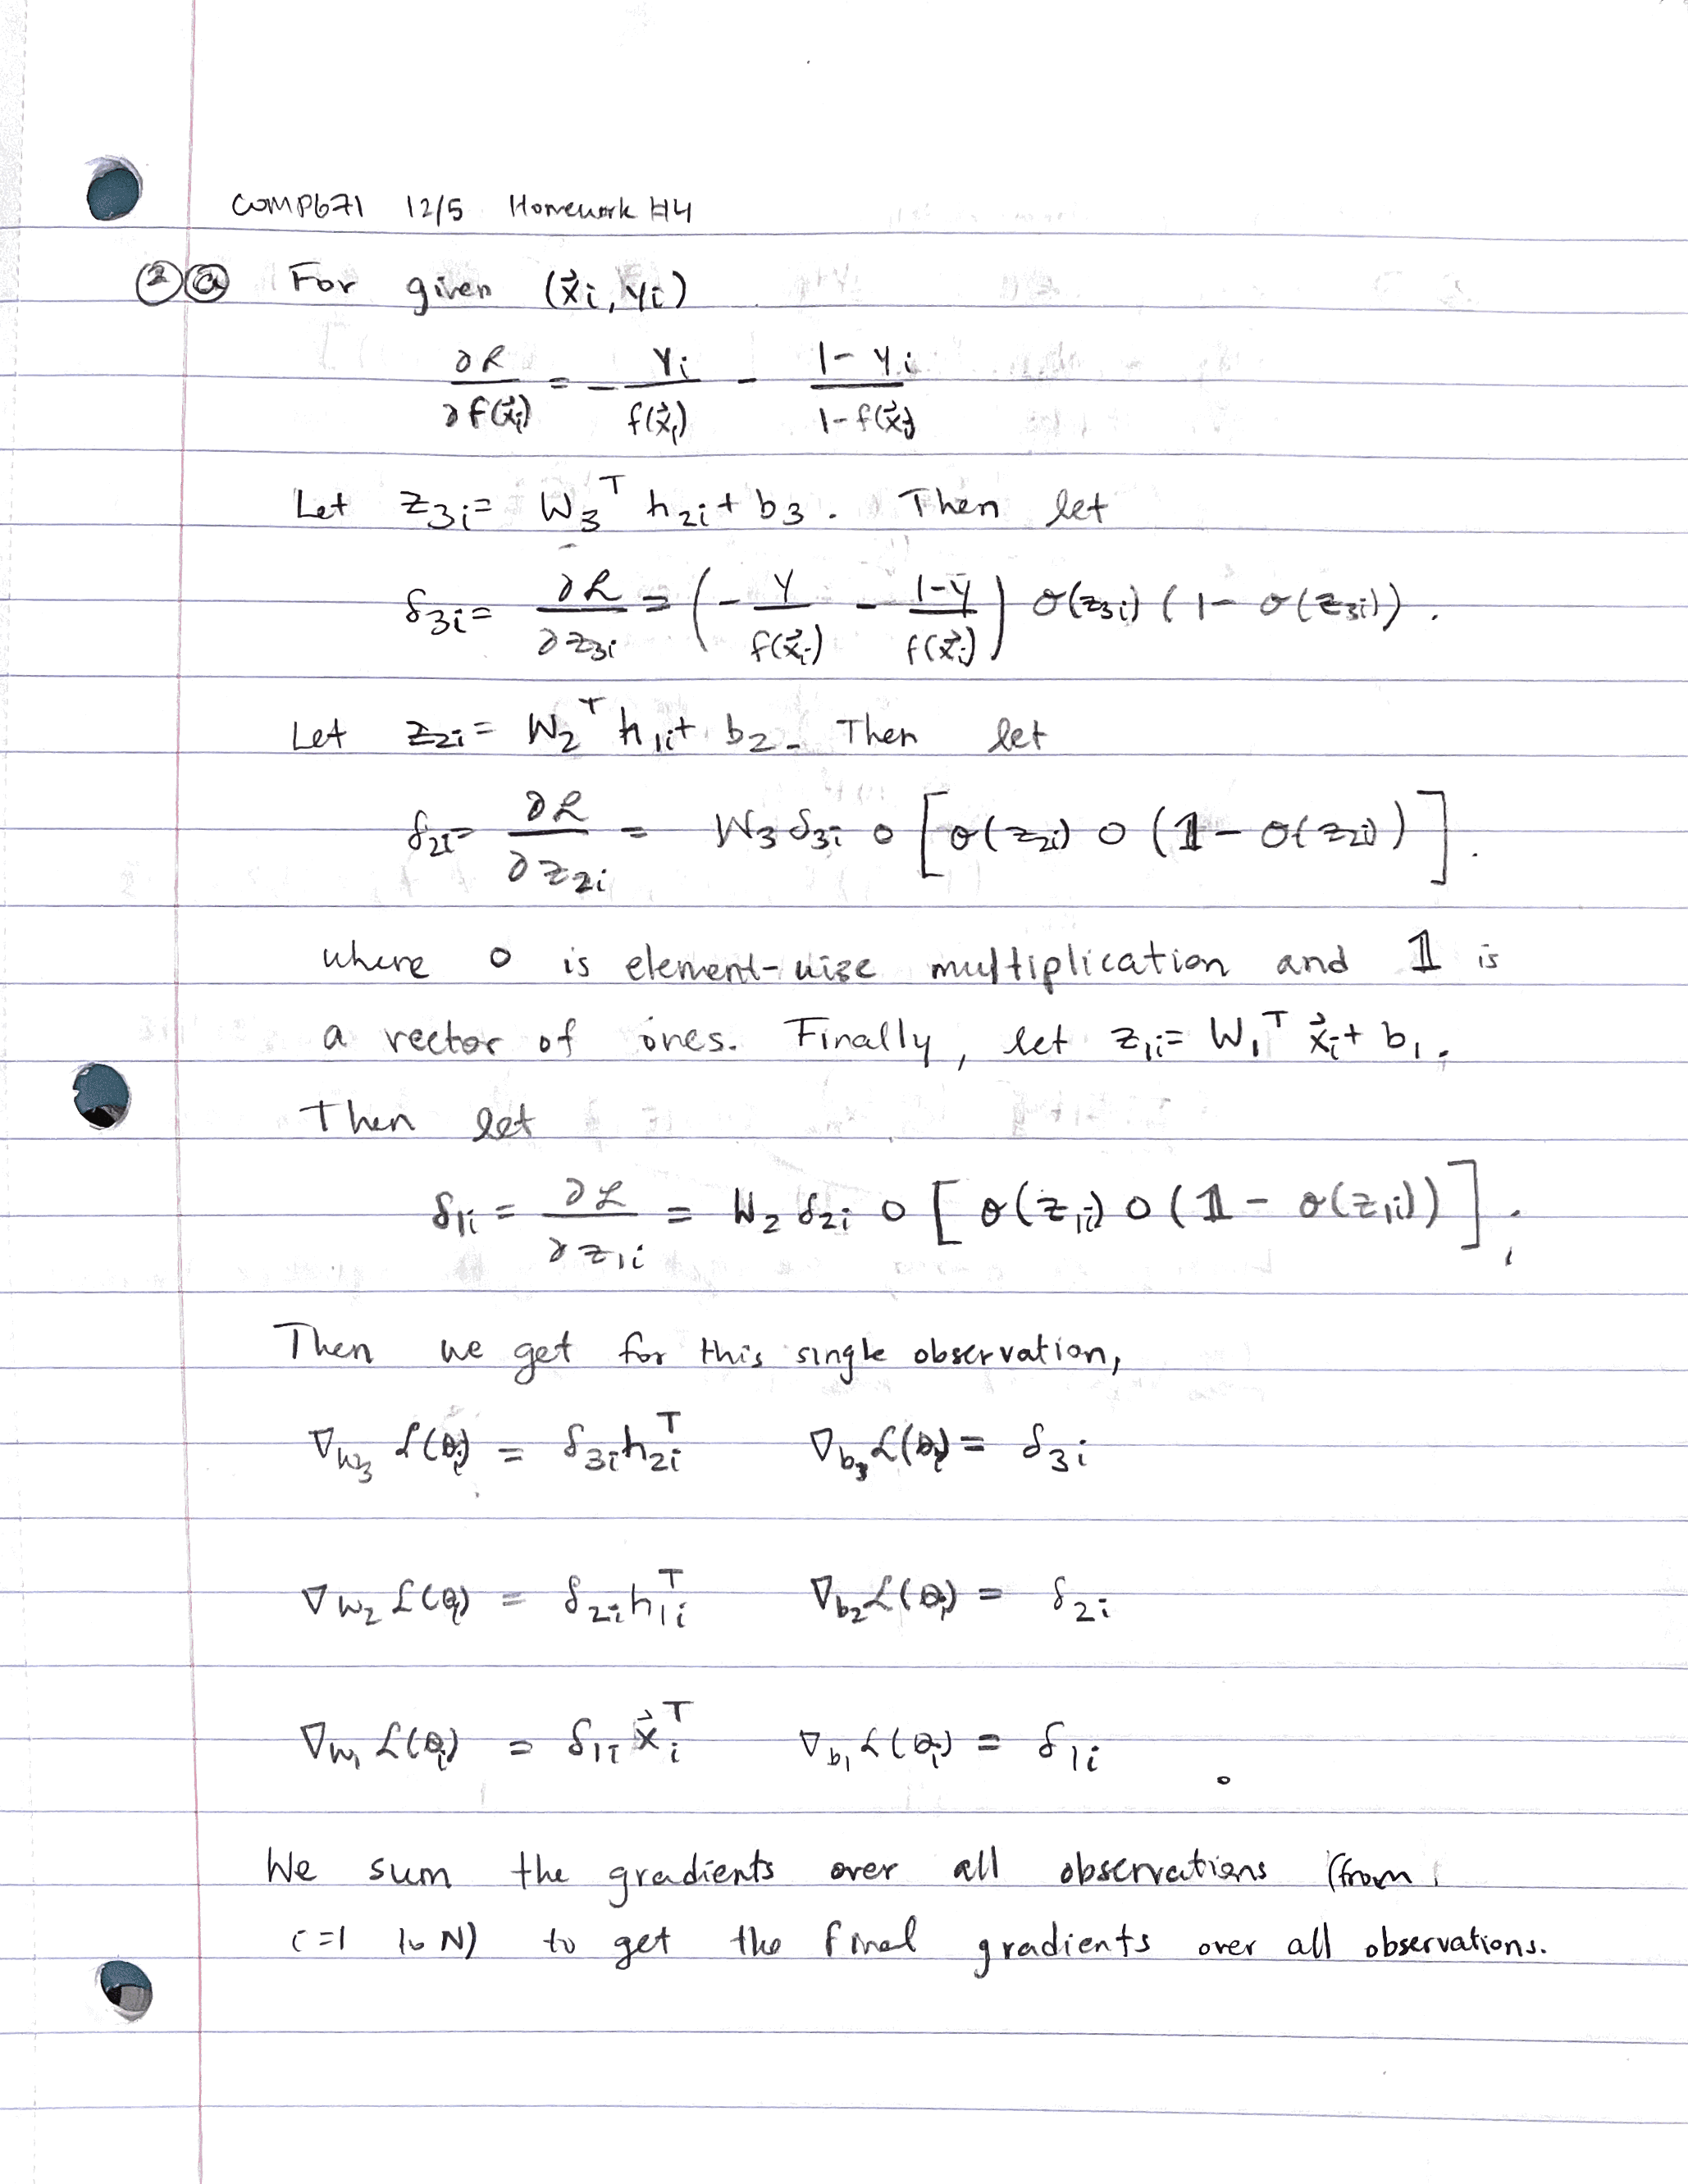

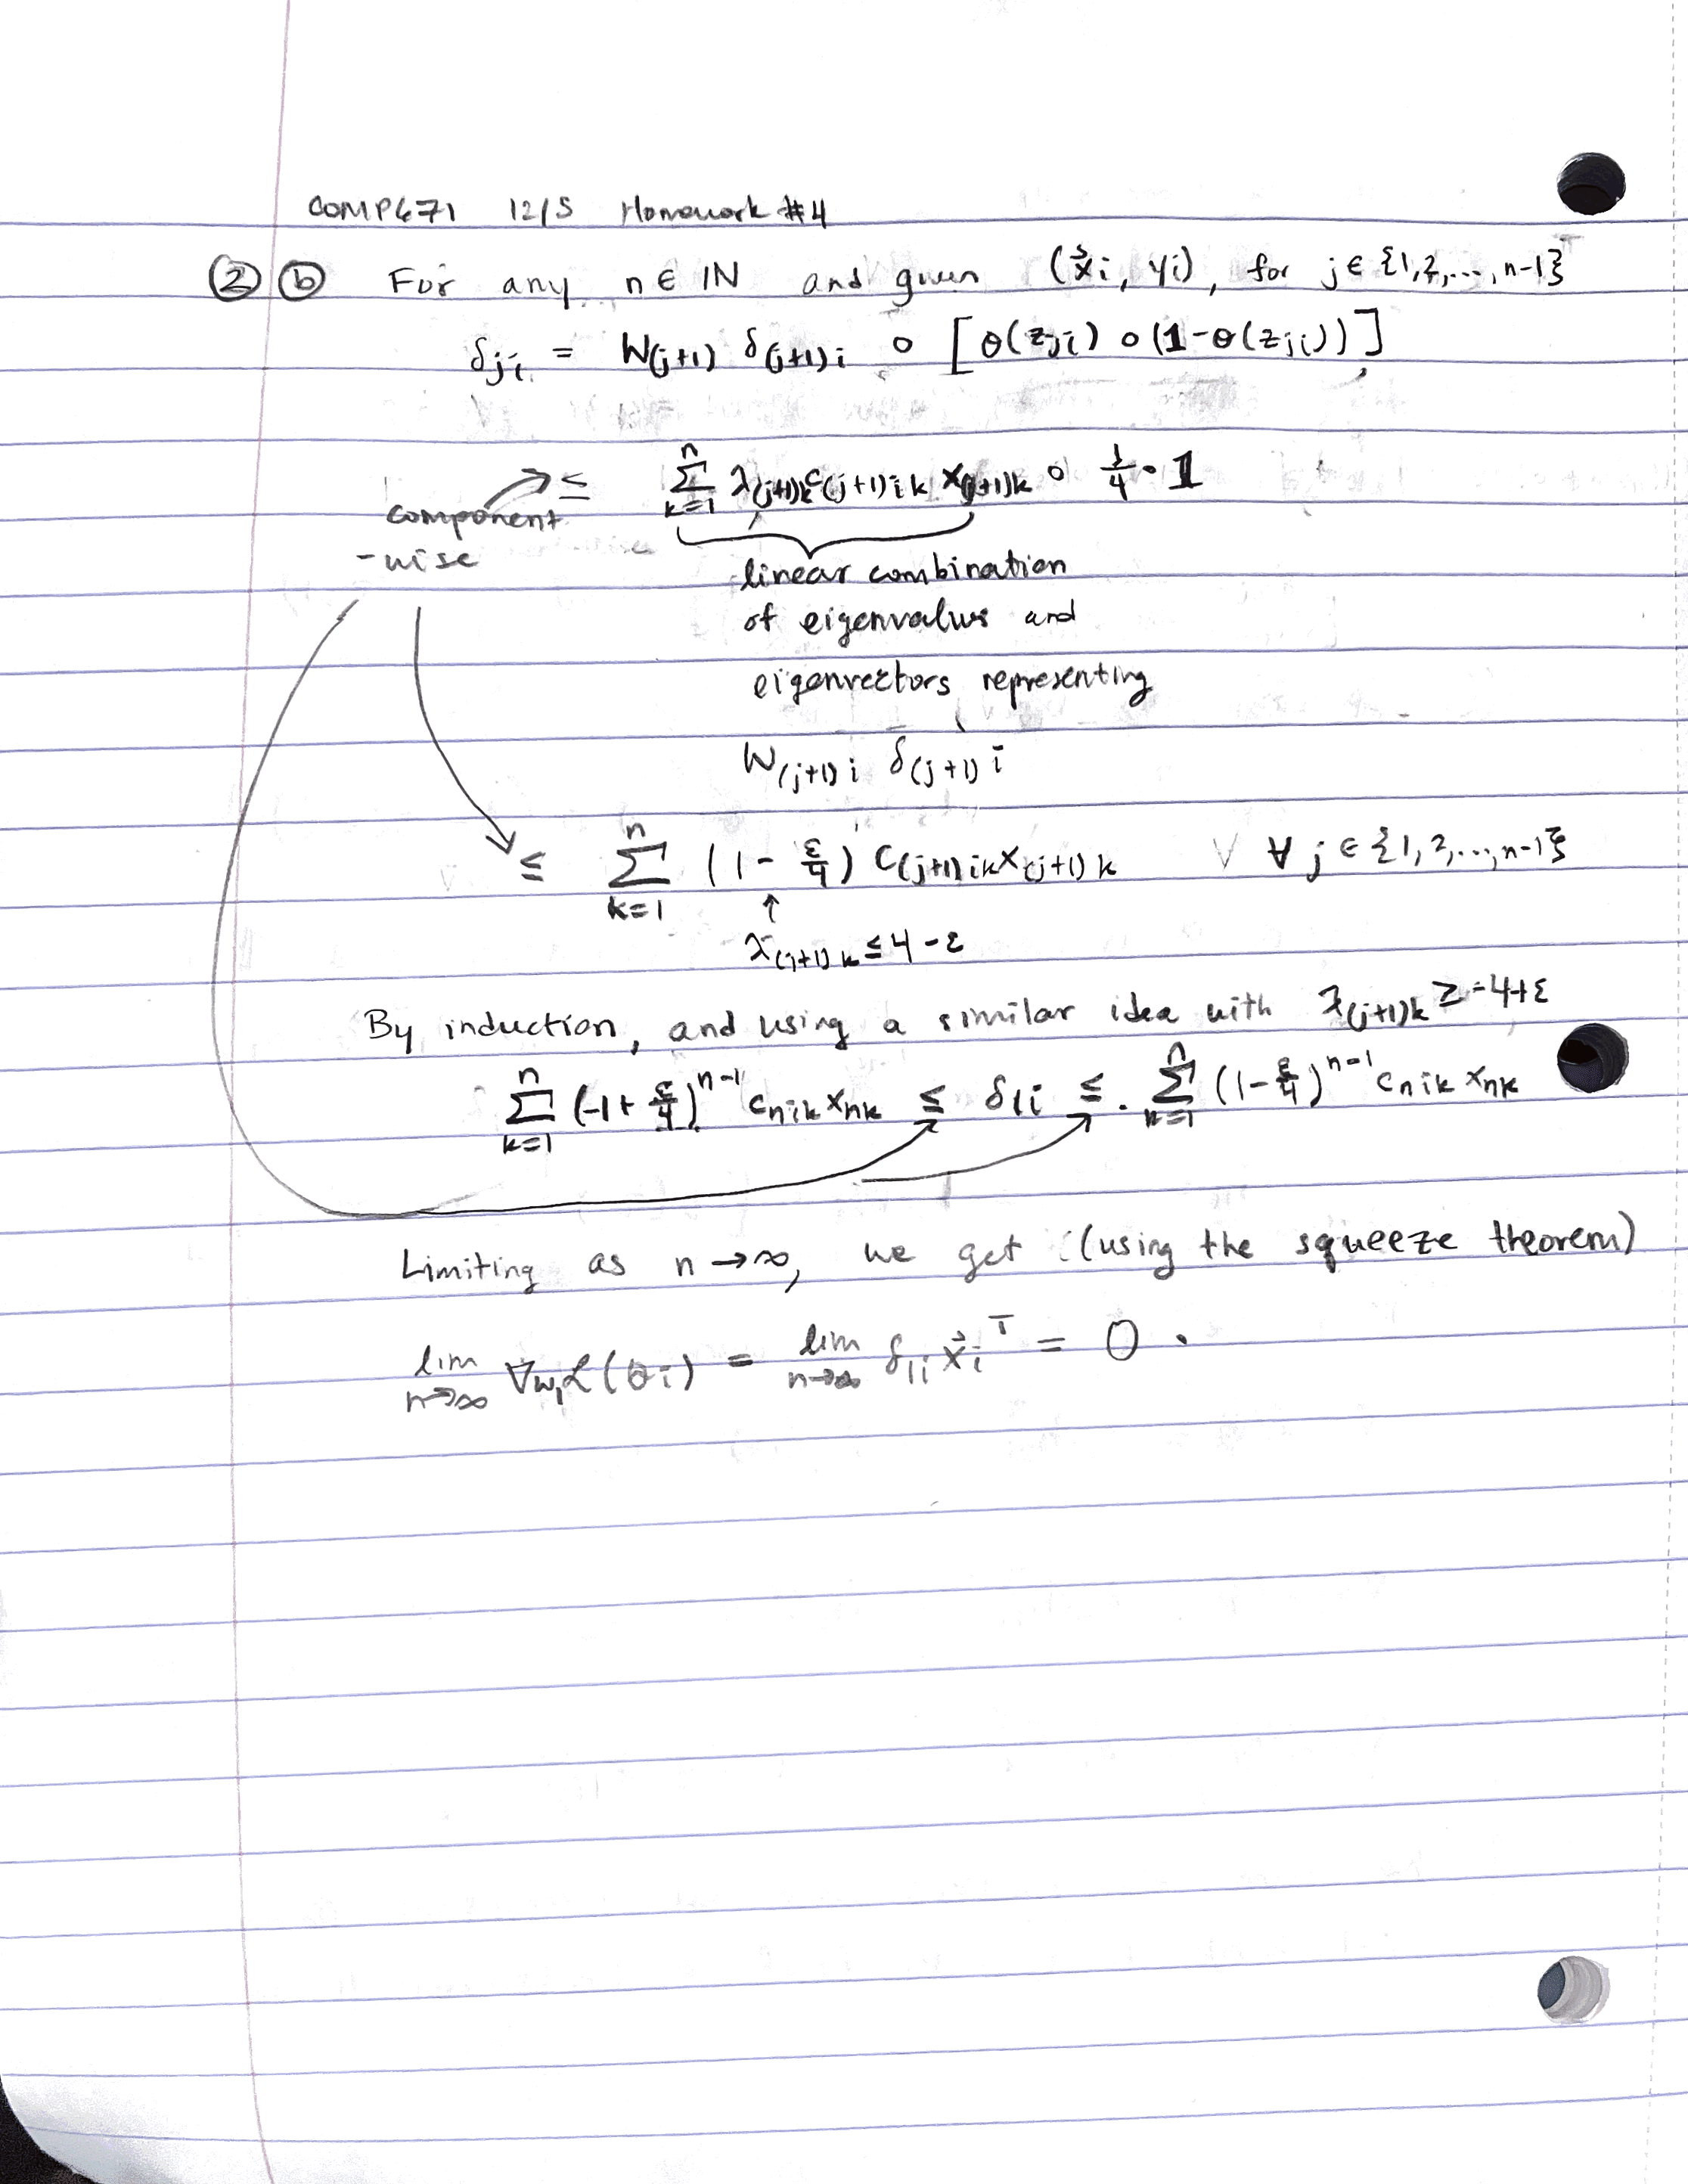

<hr style="height:2px;border-width:0;color:gray;background-color:black">

$\large \mathbf{3}$

In [1]:
# !pip3 install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import random_split
from torchvision import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [3]:
##Do Not Touch This Cell

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(dim = 1)
  
    def forward(self, x):
    
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = self.softmax(x)
        return output

In [4]:
##Do Not Touch This Cell

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=.01,
                      momentum=0.5)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on CPU...


In [5]:
##Do Not Touch This Cell

max_epochs = 30
batch_size_train = 64
batch_size_test = 1


random_seed = 671
torch.manual_seed(random_seed)

In [6]:
train_set = datasets.MNIST('mnist_data', train=True, download=True,
         transform=torchvision.transforms.ToTensor())
     
test_set =  datasets.MNIST('mnist_data', train=False, download=True,
         transform=torchvision.transforms.ToTensor())
                           
all_MNIST = train_set + test_set

##TODO: Split the set into 50% train, 50% test (there are 70K total images)
train_amt = int(len(all_MNIST)/2)
test_amt = int(len(all_MNIST)/2)
train_set, test_set = random_split(all_MNIST,[train_amt, test_amt])


train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_train, shuffle=True)
train_loader_test = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size_test, shuffle=True)   
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size_test, shuffle=True)


In [7]:
##TODO: Implement Training Loop
##Make sure to keep track of avg epoch losses in lists

def train(net):
    losses = []
    #TODO: set net to train mode
    net.train()
    
    for epoch in range(max_epochs):
        print(epoch)
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            ##TODO: pass the data into the network and store the output 
            pred = net(data)
          
            ##TODO: Calculate the negative log likelihood between the output and target 
            loss_fn = nn.NLLLoss()
            loss = loss_fn(pred, target)
            
            ##TODO: Perform backpropagation 
            loss.backward()
            
            optimizer.step()

            ##TODO: Add the loss to epoch_loss.
            ##HINT: the loss variable is currently a tensor. Use loss.item() 
            ##to get the scalar value
            epoch_loss += loss.item()
            
        #TODO: append average epoch loss to losses list
        losses.append(epoch_loss/len(train_loader))
        
            
    return losses


In [8]:
losses = train(net)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


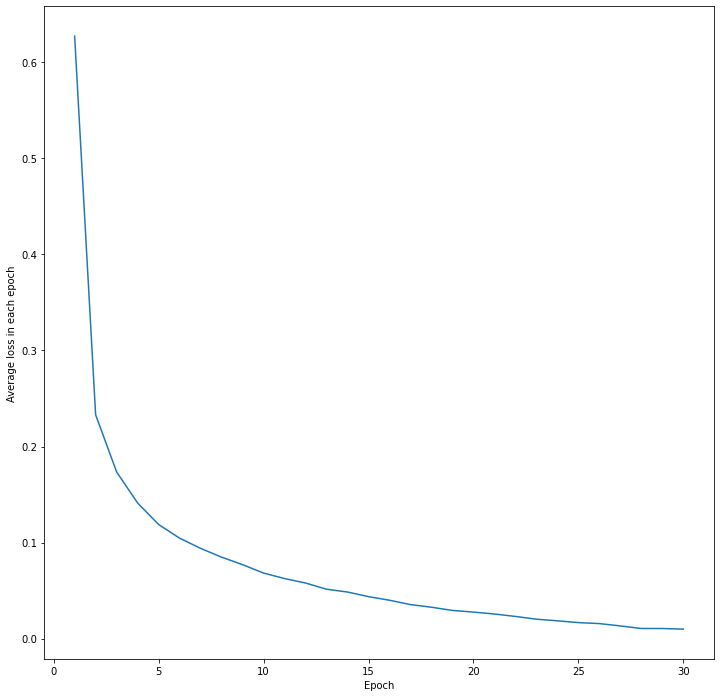

In [9]:
##TODO: Plot losses
##Make sure to label axes
plt.figure(figsize=(12,12))
plt.plot(range(1,max_epochs+1), losses)
plt.ylabel('Average loss in each epoch')
plt.xlabel('Epoch')
plt.show()

When does the network start to converge?

The rate of convergence starts to decrease at the second epoch. The loss reduces much less from epoch 2 to 3, as compared to frome epoch 1 to 2. If we had a validation set, we could probably expect that the minimum of the loss on the validation set would be near the first few epochs, since that's where the rate of convergence is the fastest.

In [10]:
##Test on the training and test set and get the confusion matrix

def get_confusion_matrix(net, data_loader):
    predictions = []
    targets = []
    
    #TODO: set network to evaluation mode
    net.eval()
   
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            ##TODO: pass the data into the network and update predictions and target list
            pred = net(data)
            
            ##TODO: update predictions list and targets list
            predictions.append(pred.argmax(1).item())
            targets.append(target.item())
            
            
            if batch_idx % 5000 == 0:
                print('Finished Image #', batch_idx)
               
    
    return confusion_matrix(targets, predictions), np.array(predictions), np.array(targets)

In [11]:
##get confusion matrices for training and test sets
train_confusion_matrix, train_predictions, train_targets = get_confusion_matrix(net, train_loader_test)
test_confusion_matrix, test_predictions, test_targets = get_confusion_matrix(net, test_loader)

Finished Image # 0
Finished Image # 5000
Finished Image # 10000
Finished Image # 15000
Finished Image # 20000
Finished Image # 25000
Finished Image # 30000
Finished Image # 0
Finished Image # 5000
Finished Image # 10000
Finished Image # 15000
Finished Image # 20000
Finished Image # 25000
Finished Image # 30000


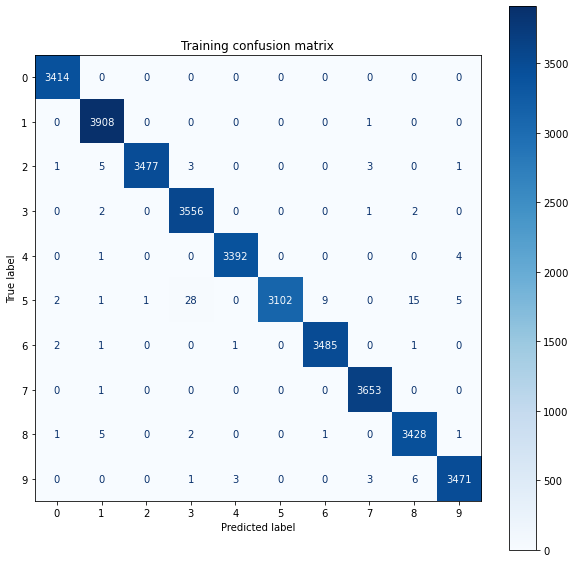

------------------------------------------------------------


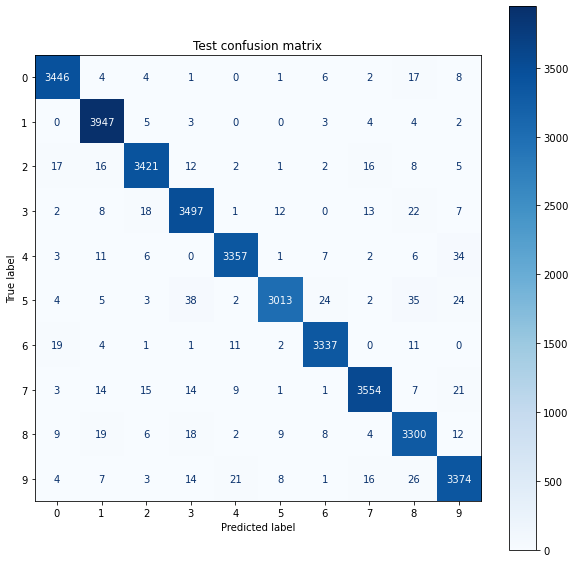

In [12]:
##TODO: print Confusion matrices
##create displays of confusion matrices
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix) 
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix) 

##plot using pyplot
fig, ax = plt.subplots(figsize=(10,10))
train_disp.plot(ax=ax,cmap='Blues')
plt.title('Training confusion matrix')
plt.show()
print('------------------------------------------------------------')
fig, ax = plt.subplots(figsize=(10,10))
test_disp.plot(ax=ax,cmap='Blues')
plt.title('Test confusion matrix')
plt.show()

In [13]:
##TODO: Compute Accuracies
print("Accuracy on the training set: " + str(accuracy_score(train_targets, train_predictions)))
print("Accuracy on the training set: " + str(accuracy_score(test_targets, test_predictions)))


Accuracy on the training set: 0.9967428571428572
Accuracy on the training set: 0.9784571428571428


Is the model overfitting?

The model may have slight overfitting, but very small. It seems the accuracy on the test set was very close to the training set as well, which signals not much overfitting.

Which images seems to get confused the most? Intiutively, why does that make sense?

Relative to the small number of errors, 4 and 9 get confused a lot, 3's get confused for 5's a lot, 7's and 9's get confused sometimes. These numbers that get confuse the net are the same that confuse us when we're watching people write on say a whiteboard. So it makes inuitive sense. Also, some people write their 4's in different ways, one way is closed top similar to 9 and the other way has open top.

In [14]:
##For convenience, here is the dataset in flattened numpy arrays for the rest of problem

trainset_list = list(zip(*train_set))
X_train = np.array([trainset_list[0][index].numpy().flatten() for index in range(train_amt)])

Y_train = np.array([trainset_list[1][index] for index in range(train_amt)])

testset_list = list(zip(*test_set))
X_test = np.array([testset_list[0][index].numpy().flatten() for index in range(test_amt)])

Y_test = np.array([testset_list[1][index] for index in range(test_amt)])

In [15]:
##TODO: Fit a logistic regression model on the training set
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

/Users/pavanchaudhari/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

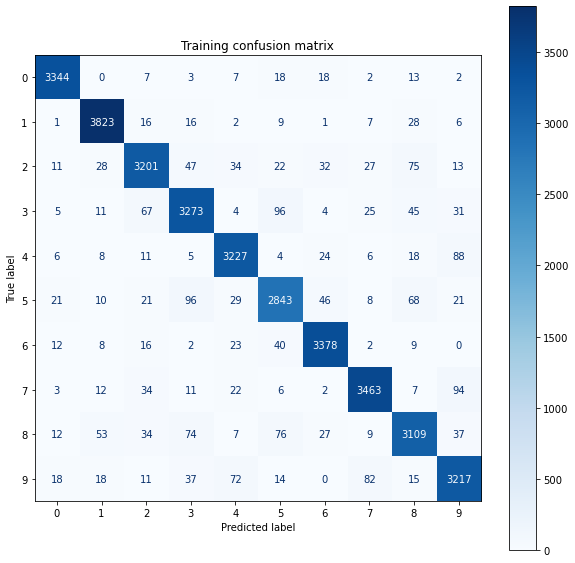

------------------------------------------------------------


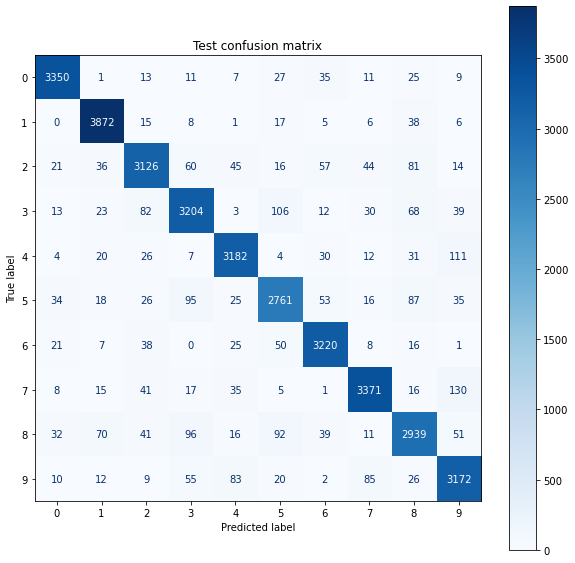

In [16]:
##TODO: For both the training and test set, get their confusion matrices and accuracies
##predictions
train_pred = log_reg.predict(X_train)
test_pred = log_reg.predict(X_test)

##create confusion matrices and displays
train_confusion_matrix = confusion_matrix(Y_train, train_pred)
test_confusion_matrix = confusion_matrix(Y_test, test_pred)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_confusion_matrix) 
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix) 

##plot using pyplot
fig, ax = plt.subplots(figsize=(10,10))
train_disp.plot(ax=ax,cmap='Blues')
plt.title('Training confusion matrix')
plt.show()
print('------------------------------------------------------------')
fig, ax = plt.subplots(figsize=(10,10))
test_disp.plot(ax=ax,cmap='Blues')
plt.title('Test confusion matrix')
plt.show()

In [17]:
##compute and print out accuracies
print("Accuracy on the training set: " + str(accuracy_score(Y_train, train_pred)))
print("Accuracy on the training set: " + str(accuracy_score(Y_test, test_pred)))

Accuracy on the training set: 0.9393714285714285
Accuracy on the training set: 0.9199142857142857


Is  it overfitting?  Does it get confused on the same images?

The model may have slight overfitting, but very small. It seems the accuracy on the training set was very high as well, which signals not much overfitting. It gets confused on mostly the same images as the net except it gets confused more of the time. It also gets confused more in general.

In [18]:
##TODO: Run Kmeans clustering (k = 10) on TEST set
##Use random restarts, 5 restarts is fine, choose solution with lowest k-means objective
##Assign each cluster to the class with the majority label
km = KMeans(n_clusters=10, init='random', n_init=5)
km.fit(X_test)

KMeans(init='random', n_clusters=10, n_init=5)

In [44]:
##save modes for relabelling the points
relabels = {}
for label in range(10):
    ##dictionary of points
    d = np.array([0]*10)
    for i in range(len(km.labels_)):
        ##count this point only if it's in the cluster
        if km.labels_[i]==label:
            ##save y value to find the mode later
            d[Y_test[i]] += 1
    ##save mode for that label
    relabels[label] = np.argmax(d)

preds = [relabels[i] for i in km.labels_]

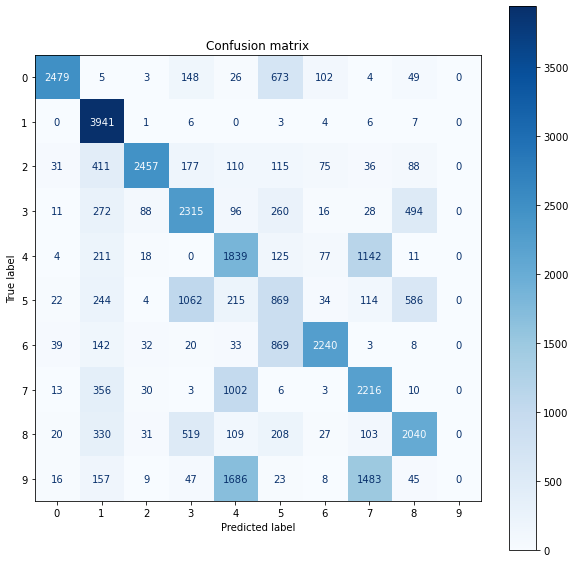

In [45]:
##TODO: Get confusion matrix and accuracy again
##create confusion matrices and displays
cm = confusion_matrix(Y_test,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 

##plot using pyplot
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap='Blues')
plt.title('Confusion matrix')
plt.show()

In [46]:
print("Accuracy on the test set: " + str(accuracy_score(Y_test, preds)))

Accuracy on the test set: 0.5827428571428571


How does its performance compare to the other methods? 

The kmeans algorithm performs very poorly compared to the other methods, both in terms of accuracy and confusion. It couldn't even guess any 9's.